# 📊 Extracción y Análisis de Datos Financieros de la SEC

---

## Script para extraer datos fundamentales de empresas desde la API pública de la SEC


---

### 🎯 Objetivos:
- Extraer datos financieros oficiales de la SEC (gratis)
- Almacenar en base de datos SQLite para persistencia
- Analizar métricas fundamentales (Net Income, Revenues, ROE, etc.)
- Generar visualizaciones comparativas profesionales

### ⚠️ IMPORTANTE:
Antes de ejecutar, **debes cambiar el `USER_AGENT`** en la Celda 2 con tu nombre y email real. La SEC te bloquea si no te identificás.

### 🌐 ACCESO UNIVERSAL:
Este notebook descarga automáticamente la lista completa de tickers desde la SEC (más de 12,000 empresas). No hay nada hardcodeado - funciona con cualquier empresa que reporte a la SEC.

---

## 📦 Celda 1: Importación de Librerías

Instalá las dependencias si es necesario:  
```bash
pip install requests pandas matplotlib seaborn openpyxl
```

In [1]:
import requests
import sqlite3
import pandas as pd
import json
import time
from datetime import datetime
from typing import Dict, List, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Librerías importadas correctamente
📅 Fecha de ejecución: 2026-02-15 01:50:31


## ⚙️ Celda 2: Configuración Global

### 🔑 CONFIGURACIÓN OBLIGATORIA

**⚠️ CAMBIAR CON TUS DATOS:**  
La SEC requiere que identifiques tu aplicación con nombre y email. Si no lo hacés, te bloquean la IP automáticamente.

In [2]:
# 🔑 CAMBIAR ESTO CON TU NOMBRE Y EMAIL REAL
USER_AGENT = "Federico Analista federico.finanzas@gmail.com"  # ⚠️ MODIFICAR AQUÍ

# URLs base de la API
SEC_API_BASE = "https://data.sec.gov/api/xbrl/companyfacts"
SEC_COMPANY_TICKERS = "https://www.sec.gov/files/company_tickers.json"

# Configuración de rate limiting (máximo 10 requests por segundo)
REQUEST_DELAY = 0.11  # 110ms entre requests para estar seguro

# Base de datos
DB_PATH = "sec_financial_data.db"

print("⚙️  Configuración cargada")
print(f"👤 User Agent: {USER_AGENT}")
print(f"💾 Base de datos: {DB_PATH}")
print(f"⏱️  Delay entre requests: {REQUEST_DELAY}s")

⚙️  Configuración cargada
👤 User Agent: Federico Analista federico.finanzas@gmail.com
💾 Base de datos: sec_financial_data.db
⏱️  Delay entre requests: 0.11s


## 🔧 Celda 3: Funciones de Utilidad para la API

Estas funciones manejan la comunicación con la API de la SEC:
- **obtener_cik_desde_ticker()**: Descarga la lista completa de tickers desde la SEC y busca el CIK correspondiente
  - Sin diccionarios hardcodeados
  - Busca en tiempo real desde https://www.sec.gov/files/company_tickers.json
  - Soporta más de 12,000 empresas automáticamente
- **extraer_datos_sec()**: Descarga los datos financieros completos en formato XBRL

In [3]:
def obtener_cik_desde_ticker(ticker: str) -> Optional[str]:
    """
    Convierte un ticker (ej: 'AAPL') a su CIK (Central Index Key).
    
    Descarga la lista completa de tickers desde la SEC y busca el CIK correspondiente.
    
    El CIK es el identificador único de 10 dígitos que usa la SEC.
    Por ejemplo: AAPL -> 0000320193
    
    Args:
        ticker: Símbolo bursátil (ej: 'AAPL', 'MSFT', 'GOOGL')
    
    Returns:
        CIK con formato de 10 dígitos o None si no se encuentra
    """
    try:
        print(f"🔍 Buscando CIK para ticker: {ticker}")
        
        # Headers dinámicos según el host
        headers = {
            "User-Agent": USER_AGENT,
            "Accept-Encoding": "gzip, deflate"
        }
        
        # Descargar el archivo de tickers desde la SEC
        response = requests.get(
            SEC_COMPANY_TICKERS,
            headers=headers,
            timeout=10
        )
        response.raise_for_status()
        
        # El JSON tiene estructura: {"0": {"cik_str": 320193, "ticker": "AAPL", "title": "Apple Inc."}, ...}
        companies = response.json()
        
        # Buscar el ticker en el diccionario
        ticker_upper = ticker.upper()
        
        for company_data in companies.values():
            if company_data['ticker'].upper() == ticker_upper:
                # Convertir CIK a string con padding de ceros (10 dígitos)
                cik = str(company_data['cik_str']).zfill(10)
                company_name = company_data['title']
                print(f"✅ CIK encontrado: {cik} ({company_name})")
                return cik
        
        print(f"❌ No se encontró CIK para el ticker: {ticker}")
        print(f"💡 Verificá que el ticker esté correctamente escrito")
        return None
        
    except requests.exceptions.HTTPError as e:
        print(f"❌ Error HTTP al buscar CIK: {e}")
        print(f"💡 Código de estado: {e.response.status_code}")
        if e.response.status_code == 403:
            print(f"⚠️  Posible bloqueo por User-Agent. Verificá que hayas configurado tu email.")
        return None
    except requests.exceptions.RequestException as e:
        print(f"❌ Error de conexión al buscar CIK: {e}")
        return None
    except Exception as e:
        print(f"❌ Error inesperado al buscar CIK: {e}")
        return None


def extraer_datos_sec(cik: str) -> Optional[Dict]:
    """
    Extrae los datos financieros completos de una empresa desde la API de la SEC.
    
    La API devuelve datos en formato XBRL (eXtensible Business Reporting Language)
    que es el estándar para reportes financieros estructurados.
    
    Args:
        cik: Central Index Key de 10 dígitos
    
    Returns:
        Diccionario con los datos financieros o None si hay error
    """
    url = f"{SEC_API_BASE}/CIK{cik}.json"
    
    try:
        print(f"📥 Descargando datos de: {url}")
        
        # Headers específicos para data.sec.gov
        headers = {
            "User-Agent": USER_AGENT,
            "Accept-Encoding": "gzip, deflate"
        }
        
        response = requests.get(
            url,
            headers=headers,
            timeout=30
        )
        response.raise_for_status()
        
        data = response.json()
        
        # Información básica de la empresa
        entity_name = data.get('entityName', 'N/A')
        print(f"✅ Datos descargados: {entity_name}")
        print(f"📊 Conceptos disponibles: {len(data.get('facts', {}).get('us-gaap', {}))}")
        
        # Respetar el rate limit de la SEC
        time.sleep(REQUEST_DELAY)
        
        return data
        
    except requests.exceptions.HTTPError as e:
        if e.response.status_code == 404:
            print(f"❌ CIK no encontrado: {cik}")
        elif e.response.status_code == 403:
            print(f"❌ Acceso bloqueado (403). Verificá tu User-Agent.")
        else:
            print(f"❌ Error HTTP {e.response.status_code}: {e}")
        return None
    except Exception as e:
        print(f"❌ Error al extraer datos: {e}")
        return None

print("✅ Funciones de API definidas")

✅ Funciones de API definidas


## 💾 Celda 4: Configuración de Base de Datos

Creamos una base de datos SQLite con dos tablas:
- **companies**: Información básica de cada empresa
- **financial_facts**: Métricas financieras con dimensionalidad temporal

In [4]:
def crear_base_datos():
    """
    Crea la estructura de la base de datos SQLite.
    
    Diseño de tablas:
    - companies: Información básica de cada empresa
    - financial_facts: Métricas financieras con dimensionalidad temporal
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    
    # Tabla de empresas
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS companies (
            cik TEXT PRIMARY KEY,
            ticker TEXT,
            entity_name TEXT,
            last_updated TIMESTAMP,
            UNIQUE(cik)
        )
    """)
    
    # Tabla de métricas financieras
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS financial_facts (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            cik TEXT,
            concept TEXT,
            taxonomy TEXT,
            label TEXT,
            description TEXT,
            unit TEXT,
            fiscal_year INTEGER,
            fiscal_period TEXT,
            value REAL,
            filed_date TEXT,
            form_type TEXT,
            FOREIGN KEY (cik) REFERENCES companies(cik),
            UNIQUE(cik, concept, fiscal_year, fiscal_period, unit)
        )
    """)
    
    # Índices para optimizar consultas
    cursor.execute("""
        CREATE INDEX IF NOT EXISTS idx_cik_concept 
        ON financial_facts(cik, concept)
    """)
    
    cursor.execute("""
        CREATE INDEX IF NOT EXISTS idx_fiscal_year 
        ON financial_facts(fiscal_year)
    """)
    
    conn.commit()
    conn.close()
    
    print("✅ Base de datos creada/verificada")
    print(f"📁 Ubicación: {Path(DB_PATH).absolute()}")

# Crear la base de datos
crear_base_datos()

✅ Base de datos creada/verificada
📁 Ubicación: d:\Users\User\Documents\Archivos Python VSCODE\SEC data extraction\notebooks\sec_financial_data.db


## 💿 Celda 5: Funciones de Persistencia

Estas funciones guardan y recuperan datos de la base de datos SQLite.

In [5]:
def guardar_empresa(cik: str, ticker: str, entity_name: str):
    """Guarda o actualiza la información básica de una empresa."""
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    
    cursor.execute("""
        INSERT OR REPLACE INTO companies (cik, ticker, entity_name, last_updated)
        VALUES (?, ?, ?, ?)
    """, (cik, ticker, entity_name, datetime.now()))
    
    conn.commit()
    conn.close()


def guardar_datos_financieros(cik: str, datos_sec: Dict):
    """
    Procesa y guarda los datos financieros en la base de datos.
    
    Extrae los conceptos US-GAAP (Generally Accepted Accounting Principles)
    que son las métricas financieras estandarizadas.
    """
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    
    facts = datos_sec.get('facts', {})
    us_gaap = facts.get('us-gaap', {})
    
    registros_insertados = 0
    
    for concept, concept_data in us_gaap.items():
        label = concept_data.get('label', concept)
        description = concept_data.get('description', '')
        
        # Procesar cada unidad de medida (USD, shares, etc.)
        for unit, unit_data in concept_data.get('units', {}).items():
            for entry in unit_data:
                # Solo guardamos datos con año fiscal
                fy = entry.get('fy')
                if not fy:
                    continue
                
                try:
                    cursor.execute("""
                        INSERT OR IGNORE INTO financial_facts
                        (cik, concept, taxonomy, label, description, unit, 
                         fiscal_year, fiscal_period, value, filed_date, form_type)
                        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    """, (
                        cik,
                        concept,
                        'us-gaap',
                        label,
                        description,
                        unit,
                        int(fy),
                        entry.get('fp', ''),
                        float(entry.get('val', 0)),
                        entry.get('filed', ''),
                        entry.get('form', '')
                    ))
                    registros_insertados += cursor.rowcount
                except Exception as e:
                    continue
    
    conn.commit()
    conn.close()
    
    print(f"💾 Registros insertados: {registros_insertados}")


def empresa_existe_en_db(cik: str) -> bool:
    """Verifica si una empresa ya está en la base de datos."""
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    
    cursor.execute("SELECT 1 FROM companies WHERE cik = ?", (cik,))
    existe = cursor.fetchone() is not None
    
    conn.close()
    return existe

print("✅ Funciones de persistencia definidas")

✅ Funciones de persistencia definidas


## 🎯 Celda 6: Función Principal de Extracción

Esta función orquesta todo el proceso: buscar CIK, descargar datos, guardar en DB.

In [6]:
def procesar_empresa(ticker: str, forzar_actualizacion: bool = False):
    """
    Función orquestadora que coordina todo el proceso de extracción.
    
    Args:
        ticker: Símbolo bursátil de la empresa
        forzar_actualizacion: Si es True, descarga datos aunque ya existan
    """
    print(f"\n{'='*80}")
    print(f"🚀 PROCESANDO: {ticker}")
    print(f"{'='*80}\n")
    
    # 1. Obtener CIK
    cik = obtener_cik_desde_ticker(ticker)
    if not cik:
        print(f"❌ No se pudo procesar {ticker}")
        return False
    
    # 2. Verificar si ya existe
    if empresa_existe_en_db(cik) and not forzar_actualizacion:
        print(f"ℹ️  {ticker} ya está en la base de datos. Usa forzar_actualizacion=True para actualizar.")
        return True
    
    # 3. Extraer datos de la SEC
    datos_sec = extraer_datos_sec(cik)
    if not datos_sec:
        print(f"❌ No se pudieron extraer datos de {ticker}")
        return False
    
    # 4. Guardar en base de datos
    entity_name = datos_sec.get('entityName', ticker)
    
    print(f"\n💾 Guardando datos en base de datos...")
    guardar_empresa(cik, ticker, entity_name)
    guardar_datos_financieros(cik, datos_sec)
    
    print(f"\n✅ {ticker} procesado exitosamente")
    return True

print("✅ Función principal definida")

✅ Función principal definida


## 📊 Celda 7: Funciones de Análisis y Consulta

Estas funciones extraen y analizan datos de la base de datos.

In [7]:
def obtener_metrica(ticker: str, concepto: str, years: int = 5) -> pd.DataFrame:
    """
    Extrae una métrica específica de la base de datos.
    
    Args:
        ticker: Símbolo bursátil
        concepto: Concepto US-GAAP (ej: 'NetIncomeLoss', 'Revenues')
        years: Número de años a consultar
    
    Returns:
        DataFrame con los valores históricos
    """
    # Primero obtener el CIK
    conn = sqlite3.connect(DB_PATH)
    cik_query = "SELECT cik FROM companies WHERE ticker = ?"
    cik_df = pd.read_sql_query(cik_query, conn, params=(ticker,))
    
    if cik_df.empty:
        conn.close()
        return pd.DataFrame()
    
    cik = cik_df.iloc[0]['cik']
    
    query = """
        SELECT 
            fiscal_year,
            fiscal_period,
            value,
            unit,
            label,
            filed_date
        FROM financial_facts
        WHERE cik = ? 
        AND concept = ?
        AND fiscal_period = 'FY'
        ORDER BY fiscal_year DESC
        LIMIT ?
    """
    
    df = pd.read_sql_query(query, conn, params=(cik, concepto, years))
    conn.close()
    
    if df.empty:
        print(f"⚠️  No se encontraron datos para {ticker} - {concepto}")
    
    return df


def listar_conceptos_disponibles(ticker: str, limite: int = 20) -> pd.DataFrame:
    """
    Lista los conceptos financieros disponibles para una empresa.
    
    Útil para explorar qué métricas podés analizar.
    """
    conn = sqlite3.connect(DB_PATH)
    cik_query = "SELECT cik FROM companies WHERE ticker = ?"
    cik_df = pd.read_sql_query(cik_query, conn, params=(ticker,))
    
    if cik_df.empty:
        conn.close()
        return pd.DataFrame()
    
    cik = cik_df.iloc[0]['cik']
    
    query = """
        SELECT DISTINCT
            concept,
            label,
            COUNT(*) as num_registros
        FROM financial_facts
        WHERE cik = ?
        GROUP BY concept, label
        ORDER BY num_registros DESC
        LIMIT ?
    """
    
    df = pd.read_sql_query(query, conn, params=(cik, limite))
    conn.close()
    
    return df


def comparar_empresas(tickers: List[str], concepto: str, years: int = 5):
    """
    Compara una métrica entre múltiples empresas.
    
    Args:
        tickers: Lista de símbolos bursátiles
        concepto: Concepto US-GAAP a comparar
        years: Años de historia
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    for ticker in tickers:
        df = obtener_metrica(ticker, concepto, years)
        
        if not df.empty:
            # Convertir a millones para mejor legibilidad
            df['value_millions'] = df['value'] / 1_000_000
            ax.plot(
                df['fiscal_year'], 
                df['value_millions'],
                marker='o',
                linewidth=2,
                label=ticker
            )
    
    ax.set_xlabel('Año Fiscal', fontsize=12, fontweight='bold')
    ax.set_ylabel('Millones (USD)', fontsize=12, fontweight='bold')
    ax.set_title(f'Comparación: {concepto}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

print("✅ Funciones de análisis definidas")

✅ Funciones de análisis definidas


## 🌐 Celda 7B (OPCIONAL): Explorar Todas las Empresas Disponibles

Esta celda descarga la lista completa de empresas desde la SEC. Podés ejecutarla para ver qué empresas están disponibles o buscar un ticker específico.

In [8]:
def listar_todas_las_empresas(filtro: str = None, limite: int = 20) -> pd.DataFrame:
    """
    Descarga y lista todas las empresas disponibles en la SEC.
    
    Args:
        filtro: Texto para filtrar por ticker o nombre (opcional)
        limite: Número máximo de resultados a mostrar
    
    Returns:
        DataFrame con ticker, CIK y nombre de empresa
    """
    try:
        print("📥 Descargando lista completa de empresas desde la SEC...")
        
        headers = {
            "User-Agent": USER_AGENT,
            "Accept-Encoding": "gzip, deflate"
        }
        
        response = requests.get(SEC_COMPANY_TICKERS, headers=headers, timeout=10)
        response.raise_for_status()
        
        companies = response.json()
        
        # Convertir a DataFrame
        data = []
        for company_data in companies.values():
            data.append({
                'ticker': company_data['ticker'],
                'cik': str(company_data['cik_str']).zfill(10),
                'nombre': company_data['title']
            })
        
        df = pd.DataFrame(data)
        
        print(f"✅ Total de empresas disponibles: {len(df):,}")
        
        # Aplicar filtro si se especifica
        if filtro:
            filtro_upper = filtro.upper()
            df = df[
                df['ticker'].str.upper().str.contains(filtro_upper) | 
                df['nombre'].str.upper().str.contains(filtro_upper)
            ]
            print(f"🔍 Resultados con filtro '{filtro}': {len(df)}")
        
        # Ordenar por ticker
        df = df.sort_values('ticker').reset_index(drop=True)
        
        return df.head(limite)
        
    except Exception as e:
        print(f"❌ Error al listar empresas: {e}")
        return pd.DataFrame()


# Ejemplos de uso:

# Ver las primeras 20 empresas
print("\n📋 Primeras 20 empresas (alfabéticamente):\n")
display(listar_todas_las_empresas(limite=20))

# Buscar empresas tech
print("\n🔍 Empresas que contienen 'TECH':\n")
display(listar_todas_las_empresas(filtro='TECH', limite=10))

# Buscar por nombre
print("\n🔍 Empresas que contienen 'TESLA':\n")
display(listar_todas_las_empresas(filtro='TESLA', limite=5))


📋 Primeras 20 empresas (alfabéticamente):

📥 Descargando lista completa de empresas desde la SEC...
✅ Total de empresas disponibles: 10,390


,ticker,cik,nombre
0,A,0001090872,"AGILENT TECHNOLOGIES, INC."
1,AA,0001675149,Alcoa Corp
2,AAAU,0001708646,Goldman Sachs Physical Gold ETF
3,AACB,0002034334,Artius II Acquisition Inc.
4,AACBR,0002034334,Artius II Acquisition Inc.
5,AACBU,0002034334,Artius II Acquisition Inc.
6,AACG,0001420529,ATA Creativity Global
7,AACO,0002099906,Abony Acquisition Corp. I
8,AAL,0000006201,American Airlines Group Inc.
9,AAM,0002012964,AA Mission Acquisition Corp.



🔍 Empresas que contienen 'TECH':

📥 Descargando lista completa de empresas desde la SEC...
✅ Total de empresas disponibles: 10,390
🔍 Resultados con filtro 'TECH': 534


,ticker,cik,nombre
0,A,0001090872,"AGILENT TECHNOLOGIES, INC."
1,AATC,0000943034,AUTOSCOPE TECHNOLOGIES CORP
2,ABAT,0001576873,AMERICAN BATTERY TECHNOLOGY Co
3,ABXXF,0001971975,Abaxx Technologies Inc.
4,ACLS,0001113232,AXCELIS TECHNOLOGIES INC
5,ADDTF,0001766868,Addtech AB/ADR
6,ADNH,0001744494,"ADVENT TECHNOLOGIES HOLDINGS, INC."
7,ADPT,0001478320,Adaptive Biotechnologies Corp
8,ADUR,0001863934,ADURO CLEAN TECHNOLOGIES INC.
9,AED,0002057673,Brand Meditech Ltd



🔍 Empresas que contienen 'TESLA':

📥 Descargando lista completa de empresas desde la SEC...
✅ Total de empresas disponibles: 10,390
🔍 Resultados con filtro 'TESLA': 1


,ticker,cik,nombre
0,TSLA,0001318605,"Tesla, Inc."


## 🏃 Celda 8: Extracción de Datos - Empresas Ejemplo

Vamos a extraer datos de empresas financieras para analizar. Esto puede tomar algunos minutos.

**Nota:** Podés cambiar la lista `EMPRESAS_EJEMPLO` por cualquier ticker que quieras analizar.

In [9]:
# Lista de empresas financieras para analizar
EMPRESAS_EJEMPLO = ['JPM', 'BAC', 'WFC', 'C', 'GS']

print("\n" + "="*80)
print("📊 EXTRAYENDO DATOS DE EMPRESAS FINANCIERAS")
print(f"📋 Empresas seleccionadas: {', '.join(EMPRESAS_EJEMPLO)}")
print("="*80 + "\n")

# Procesar cada empresa
for ticker in EMPRESAS_EJEMPLO:
    procesar_empresa(ticker, forzar_actualizacion=False)
    print("\n" + "-"*80 + "\n")

print("\n✅ EXTRACCIÓN COMPLETADA")
print(f"💾 Total de empresas procesadas: {len(EMPRESAS_EJEMPLO)}")


📊 EXTRAYENDO DATOS DE EMPRESAS FINANCIERAS
📋 Empresas seleccionadas: JPM, BAC, WFC, C, GS


🚀 PROCESANDO: JPM

🔍 Buscando CIK para ticker: JPM
✅ CIK encontrado: 0000019617 (JPMORGAN CHASE & CO)
ℹ️  JPM ya está en la base de datos. Usa forzar_actualizacion=True para actualizar.

--------------------------------------------------------------------------------


🚀 PROCESANDO: BAC

🔍 Buscando CIK para ticker: BAC
✅ CIK encontrado: 0000070858 (BANK OF AMERICA CORP /DE/)
ℹ️  BAC ya está en la base de datos. Usa forzar_actualizacion=True para actualizar.

--------------------------------------------------------------------------------


🚀 PROCESANDO: WFC

🔍 Buscando CIK para ticker: WFC
✅ CIK encontrado: 0000072971 (WELLS FARGO & COMPANY/MN)
ℹ️  WFC ya está en la base de datos. Usa forzar_actualizacion=True para actualizar.

--------------------------------------------------------------------------------


🚀 PROCESANDO: C

🔍 Buscando CIK para ticker: C
✅ CIK encontrado: 0000831001 (CITIGROUP

## 🔍 Celda 9: Análisis Exploratorio

Veamos qué conceptos financieros tenemos disponibles para la primera empresa de nuestra lista.

In [10]:
print("\n" + "="*80)
print("🔍 EXPLORANDO CONCEPTOS DISPONIBLES")
print("="*80 + "\n")

# Ver qué conceptos tenemos disponibles para la primera empresa de la lista
ticker_ejemplo = EMPRESAS_EJEMPLO[0]
print(f"📊 Conceptos principales para {ticker_ejemplo}:\n")
conceptos_df = listar_conceptos_disponibles(ticker_ejemplo, limite=15)
conceptos_df


🔍 EXPLORANDO CONCEPTOS DISPONIBLES

📊 Conceptos principales para JPM:



,concept,label,num_registros
0,AccumulatedOtherComprehensiveIncomeLossNetOfTax,"Accumulated Other Comprehensive Income (Loss),...",67
1,Assets,Assets,67
2,BeneficialInterest,Beneficial Interest Liability,67
3,CashAndDueFromBanks,Cash and Due from Banks,67
4,CommonStockParOrStatedValuePerShare,"Common Stock, Par or Stated Value Per Share",67
5,CommonStockSharesAuthorized,"Common Stock, Shares Authorized",67
6,CommonStockSharesIssued,"Common Stock, Shares, Issued",67
7,CommonStockValue,"Common Stock, Value, Issued",67
8,DeferredIncomeTaxExpenseBenefit,Deferred Income Tax Expense (Benefit),67
9,Deposits,Deposits,67


## 💰 Celda 10: Análisis Comparativo - Net Income

Comparemos la ganancia neta (Net Income) entre nuestras empresas seleccionadas.


💰 COMPARANDO NET INCOME (GANANCIA NETA)
📋 Empresas: JPM, BAC, WFC, C, GS


JPM:
 fiscal_year   value
        2025 $49.55B
        2024 $37.68B
        2023 $48.33B
        2022 $29.13B
        2021 $36.43B

BAC:
 fiscal_year   value
        2024 $27.53B
        2023 $31.98B
        2022 $17.89B
        2021 $27.43B
        2020 $28.15B

WFC:
 fiscal_year   value
        2024 $13.68B
        2023 $22.11B
        2022  $3.38B
        2021 $19.71B
        2020 $22.39B

C:
 fiscal_year   value
        2024 $14.85B
        2023 $21.95B
        2022 $11.05B
        2021 $19.40B
        2020 $18.05B

GS:
 fiscal_year   value
        2024 $11.26B
        2023 $21.64B
        2022  $9.46B
        2021  $8.47B
        2020 $10.46B

📊 Gráfico guardado: net_income_comparison.png


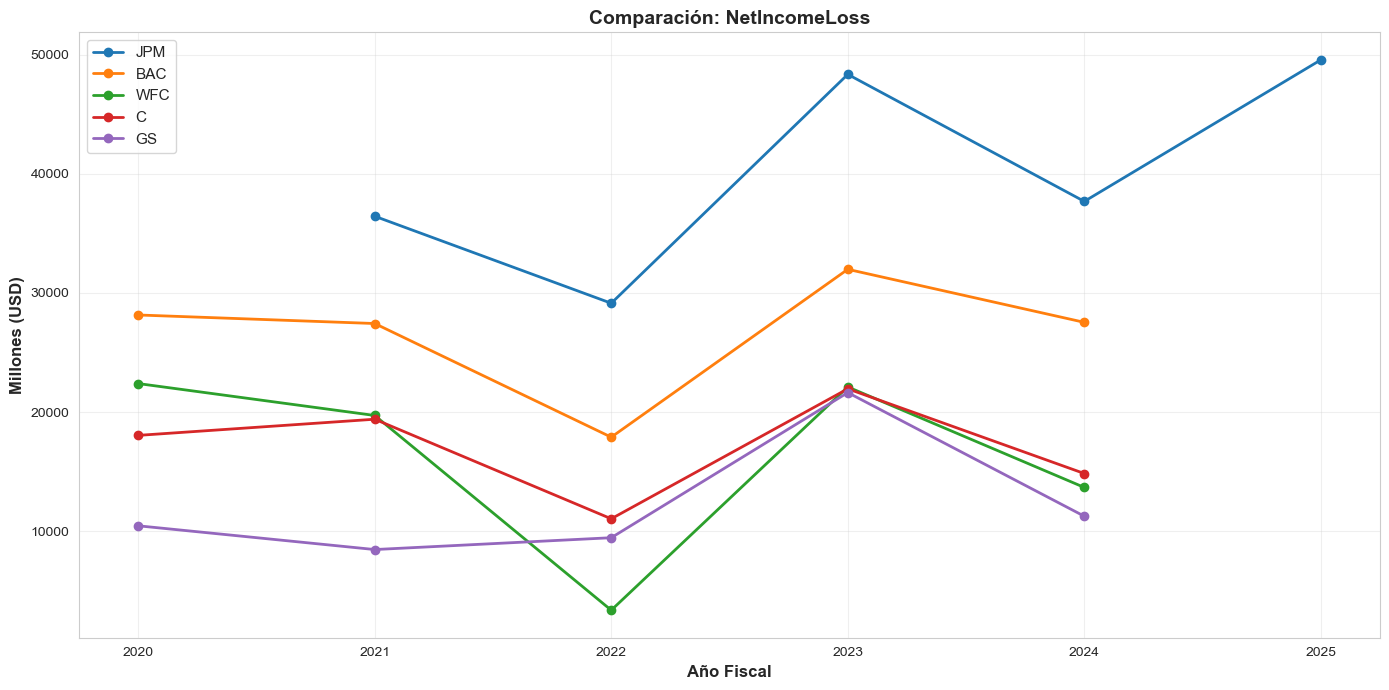

In [11]:
print("\n" + "="*80)
print("💰 COMPARANDO NET INCOME (GANANCIA NETA)")
print(f"📋 Empresas: {', '.join(EMPRESAS_EJEMPLO)}")
print("="*80 + "\n")

# Extraer Net Income de cada empresa
for ticker in EMPRESAS_EJEMPLO:
    print(f"\n{ticker}:")
    df = obtener_metrica(ticker, 'NetIncomeLoss', years=5)
    if not df.empty:
        df_display = df[['fiscal_year', 'value']].copy()
        df_display['value'] = df_display['value'].apply(lambda x: f"${x/1e9:.2f}B")
        print(df_display.to_string(index=False))

# Generar gráfico comparativo
fig = comparar_empresas(EMPRESAS_EJEMPLO, 'NetIncomeLoss', years=5)
plt.savefig('net_income_comparison.png', dpi=300, bbox_inches='tight')
print("\n📊 Gráfico guardado: net_income_comparison.png")
plt.show()

## 📈 Celda 11: Análisis Comparativo - Revenues

Ahora comparemos los ingresos (Revenues) de nuestras empresas.


📈 COMPARANDO REVENUES (INGRESOS)
📋 Empresas: JPM, BAC, WFC, C, GS


JPM:
 fiscal_year    value
        2025 $158.10B
        2024 $128.69B
        2023 $121.65B
        2022 $119.95B
        2021 $115.72B

BAC:
 fiscal_year   value
        2024 $94.95B
        2023 $89.11B
        2022 $85.53B
        2021 $91.24B
        2020 $91.02B

WFC:
 fiscal_year   value
        2019 $88.39B
        2018 $88.27B
        2017 $88.39B

C:
 fiscal_year   value
        2024 $75.34B
        2023 $71.88B
        2022 $75.50B
        2021 $75.07B
        2020 $72.85B

GS:
⚠️  No se encontraron datos para GS - Revenues
⚠️  No se encontraron datos para GS - Revenues

📊 Gráfico guardado: revenues_comparison.png


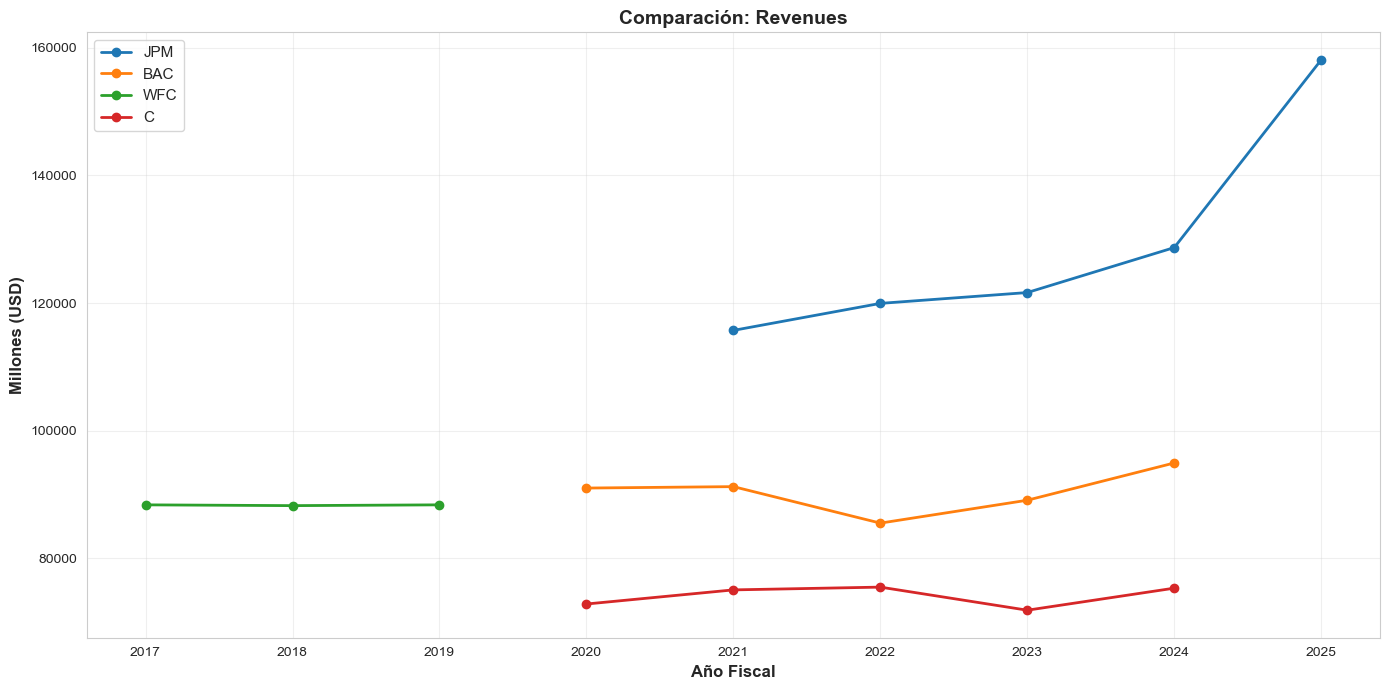

In [12]:
print("\n" + "="*80)
print("📈 COMPARANDO REVENUES (INGRESOS)")
print(f"📋 Empresas: {', '.join(EMPRESAS_EJEMPLO)}")
print("="*80 + "\n")

# Extraer Revenues de cada empresa
for ticker in EMPRESAS_EJEMPLO:
    print(f"\n{ticker}:")
    df = obtener_metrica(ticker, 'Revenues', years=5)
    if not df.empty:
        df_display = df[['fiscal_year', 'value']].copy()
        df_display['value'] = df_display['value'].apply(lambda x: f"${x/1e9:.2f}B")
        print(df_display.to_string(index=False))

# Generar gráfico comparativo
fig = comparar_empresas(EMPRESAS_EJEMPLO, 'Revenues', years=5)
plt.savefig('revenues_comparison.png', dpi=300, bbox_inches='tight')
print("\n📊 Gráfico guardado: revenues_comparison.png")
plt.show()

## 📊 Celda 12: Estadísticas de la Base de Datos

Veamos un resumen de los datos que tenemos almacenados.

In [13]:
print("\n" + "="*80)
print("📊 ESTADÍSTICAS DE LA BASE DE DATOS")
print("="*80 + "\n")

conn = sqlite3.connect(DB_PATH)

# Empresas en la base de datos
empresas_df = pd.read_sql_query("""
    SELECT 
        ticker,
        entity_name,
        last_updated
    FROM companies
    ORDER BY ticker
""", conn)

print("🏢 Empresas almacenadas:")
display(empresas_df)

# Estadísticas de datos
stats_df = pd.read_sql_query("""
    SELECT 
        c.ticker,
        COUNT(DISTINCT f.concept) as conceptos_unicos,
        COUNT(*) as total_registros,
        MIN(f.fiscal_year) as año_mas_antiguo,
        MAX(f.fiscal_year) as año_mas_reciente
    FROM companies c
    JOIN financial_facts f ON c.cik = f.cik
    GROUP BY c.ticker
    ORDER BY c.ticker
""", conn)

print("\n📈 Estadísticas de datos:")
display(stats_df)

conn.close()


📊 ESTADÍSTICAS DE LA BASE DE DATOS

🏢 Empresas almacenadas:


,ticker,entity_name,last_updated
0,AAPL,Apple Inc.,2026-02-14 19:51:47.652608
1,AMD,"ADVANCED MICRO DEVICES, INC.",2026-02-14 20:27:05.685215
2,BAC,BANK OF AMERICA CORPORATION,2026-02-14 20:30:49.359408
3,C,Citigroup Inc.,2026-02-14 20:30:55.101055
4,CSCO,"CISCO SYSTEMS, INC.",2026-02-14 20:27:01.866221
5,GOOGL,ALPHABET INC.,2026-02-14 19:51:50.680543
6,GS,"The Goldman Sachs Group, Inc.",2026-02-14 20:30:57.258188
7,IBM,INTERNATIONAL BUSINESS MACHINES CORPORATION,2026-02-14 20:26:58.023839
8,INTC,INTEL CORPORATION,2026-02-14 20:27:03.942949
9,JPM,JPMorgan Chase & Co,2026-02-14 20:30:45.762721



📈 Estadísticas de datos:


,ticker,conceptos_unicos,total_registros,año_mas_antiguo,año_mas_reciente
0,AAPL,503,9835,2009,2026
1,AMD,770,9478,2010,2025
2,BAC,875,16703,2009,2025
3,C,773,17627,2009,2025
4,CSCO,768,17695,2010,2026
5,GOOGL,521,8575,2015,2025
6,GS,611,15651,2009,2025
7,IBM,758,14884,2009,2025
8,INTC,671,11893,2009,2025
9,JPM,917,19493,2009,2025


---

## 🎯 ANÁLISIS AVANZADO - RATIOS FINANCIEROS

A partir de aquí, vamos a calcular ratios financieros clásicos.

## 📊 Celda 13: Funciones de Ratios Financieros

In [14]:
def calcular_roe(ticker: str, years: int = 5) -> pd.DataFrame:
    """
    Calcula el Return on Equity (ROE) = Net Income / Shareholders Equity
    
    ROE mide cuán eficientemente una empresa usa el capital de los accionistas
    para generar ganancias. Un ROE > 15% generalmente se considera bueno.
    """
    conn = sqlite3.connect(DB_PATH)
    
    # Obtener CIK del ticker
    cik_query = "SELECT cik FROM companies WHERE ticker = ?"
    cik = pd.read_sql_query(cik_query, conn, params=(ticker,))
    
    if cik.empty:
        print(f"❌ Ticker {ticker} no encontrado")
        conn.close()
        return pd.DataFrame()
    
    cik = cik.iloc[0]['cik']
    
    # Extraer Net Income y Shareholders Equity
    query = """
        SELECT 
            fiscal_year,
            SUM(CASE WHEN concept = 'NetIncomeLoss' THEN value END) as net_income,
            SUM(CASE WHEN concept = 'StockholdersEquity' THEN value END) as equity
        FROM financial_facts
        WHERE cik = ?
        AND fiscal_period = 'FY'
        AND concept IN ('NetIncomeLoss', 'StockholdersEquity')
        GROUP BY fiscal_year
        HAVING net_income IS NOT NULL AND equity IS NOT NULL
        ORDER BY fiscal_year DESC
        LIMIT ?
    """
    
    df = pd.read_sql_query(query, conn, params=(cik, years))
    conn.close()
    
    if not df.empty:
        df['ROE'] = (df['net_income'] / df['equity']) * 100
        df['ROE'] = df['ROE'].round(2)
    
    return df


def calcular_profit_margin(ticker: str, years: int = 5) -> pd.DataFrame:
    """
    Calcula el Profit Margin = (Net Income / Revenues) * 100
    
    Indica qué porcentaje de los ingresos se convierte en ganancia.
    """
    conn = sqlite3.connect(DB_PATH)
    
    cik_query = "SELECT cik FROM companies WHERE ticker = ?"
    cik = pd.read_sql_query(cik_query, conn, params=(ticker,))
    
    if cik.empty:
        conn.close()
        return pd.DataFrame()
    
    cik = cik.iloc[0]['cik']
    
    query = """
        SELECT 
            fiscal_year,
            SUM(CASE WHEN concept = 'NetIncomeLoss' THEN value END) as net_income,
            SUM(CASE WHEN concept = 'Revenues' THEN value END) as revenues
        FROM financial_facts
        WHERE cik = ?
        AND fiscal_period = 'FY'
        AND concept IN ('NetIncomeLoss', 'Revenues')
        GROUP BY fiscal_year
        HAVING net_income IS NOT NULL AND revenues IS NOT NULL
        ORDER BY fiscal_year DESC
        LIMIT ?
    """
    
    df = pd.read_sql_query(query, conn, params=(cik, years))
    conn.close()
    
    if not df.empty:
        df['profit_margin'] = (df['net_income'] / df['revenues']) * 100
        df['profit_margin'] = df['profit_margin'].round(2)
    
    return df


def calcular_cagr(ticker: str, concepto: str, years: int = 5) -> dict:
    """
    Calcula el CAGR (Compound Annual Growth Rate).
    
    CAGR = (Valor_Final / Valor_Inicial)^(1/años) - 1
    
    Es una métrica útil para ver el crecimiento promedio anual.
    """
    conn = sqlite3.connect(DB_PATH)
    
    cik_query = "SELECT cik FROM companies WHERE ticker = ?"
    cik = pd.read_sql_query(cik_query, conn, params=(ticker,))
    
    if cik.empty:
        conn.close()
        return None
    
    cik = cik.iloc[0]['cik']
    
    query = """
        SELECT fiscal_year, value
        FROM financial_facts
        WHERE cik = ?
        AND concept = ?
        AND fiscal_period = 'FY'
        ORDER BY fiscal_year ASC
        LIMIT ?
    """
    
    df = pd.read_sql_query(query, conn, params=(cik, concepto, years))
    conn.close()
    
    if len(df) < 2:
        return None
    
    valor_inicial = df.iloc[0]['value']
    valor_final = df.iloc[-1]['value']
    años = len(df) - 1
    
    if valor_inicial <= 0:
        return None
    
    cagr = ((valor_final / valor_inicial) ** (1 / años) - 1) * 100
    
    return {
        'ticker': ticker,
        'concepto': concepto,
        'valor_inicial': valor_inicial,
        'valor_final': valor_final,
        'años': años,
        'cagr': round(cagr, 2)
    }

print("✅ Funciones de ratios financieros definidas")

✅ Funciones de ratios financieros definidas


## 💰 Celda 14: Análisis de ROE (Return on Equity)

In [15]:
print("💰 Return on Equity (ROE) - Últimos 5 años:\n")

for ticker in EMPRESAS_EJEMPLO:
    print(f"\n{ticker}:")
    df = calcular_roe(ticker, years=5)
    if not df.empty:
        display(df[['fiscal_year', 'ROE']])
        print(f"Promedio ROE: {df['ROE'].mean():.2f}%")

💰 Return on Equity (ROE) - Últimos 5 años:


JPM:


,fiscal_year,ROE
0,2025,15.11
1,2024,12.89
2,2023,16.43
3,2022,10.43
4,2021,13.94


Promedio ROE: 13.76%

BAC:


,fiscal_year,ROE
0,2024,10.19
1,2023,11.72
2,2022,6.76
3,2021,10.34
4,2020,10.54


Promedio ROE: 9.91%

WFC:


,fiscal_year,ROE
0,2024,7.36
1,2023,12.27
2,2022,1.80
3,2021,10.68
4,2020,11.97


Promedio ROE: 8.82%

C:


,fiscal_year,ROE
0,2024,7.23
1,2023,10.91
2,2022,5.47
3,2021,9.73
4,2020,9.34


Promedio ROE: 8.54%

GS:


,fiscal_year,ROE
0,2024,9.61
1,2023,19.68
2,2022,9.86
3,2021,9.38
4,2020,11.60


Promedio ROE: 12.03%


## 📊 Celda 15: Análisis de Profit Margin

In [16]:
print("📈 Profit Margin - Últimos 5 años:\n")

for ticker in EMPRESAS_EJEMPLO:
    print(f"\n{ticker}:")
    df = calcular_profit_margin(ticker, years=5)
    if not df.empty:
        display(df[['fiscal_year', 'profit_margin']])
        print(f"Promedio Profit Margin: {df['profit_margin'].mean():.2f}%")

📈 Profit Margin - Últimos 5 años:


JPM:


,fiscal_year,profit_margin
0,2025,31.34
1,2024,29.28
2,2023,39.73
3,2022,24.29
4,2021,31.48


Promedio Profit Margin: 31.22%

BAC:


,fiscal_year,profit_margin
0,2024,28.99
1,2023,35.88
2,2022,20.92
3,2021,30.06
4,2020,30.92


Promedio Profit Margin: 29.35%

WFC:


,fiscal_year,profit_margin
0,2019,25.10
1,2018,24.85
2,2017,25.90


Promedio Profit Margin: 25.28%

C:


,fiscal_year,profit_margin
0,2024,19.70
1,2023,30.54
2,2022,14.63
3,2021,25.84
4,2020,24.77


Promedio Profit Margin: 23.10%

GS:


## 📈 Celda 16: Gráficos Comparativos de Ratios

📊 Gráfico guardado: ratios_comparison.png


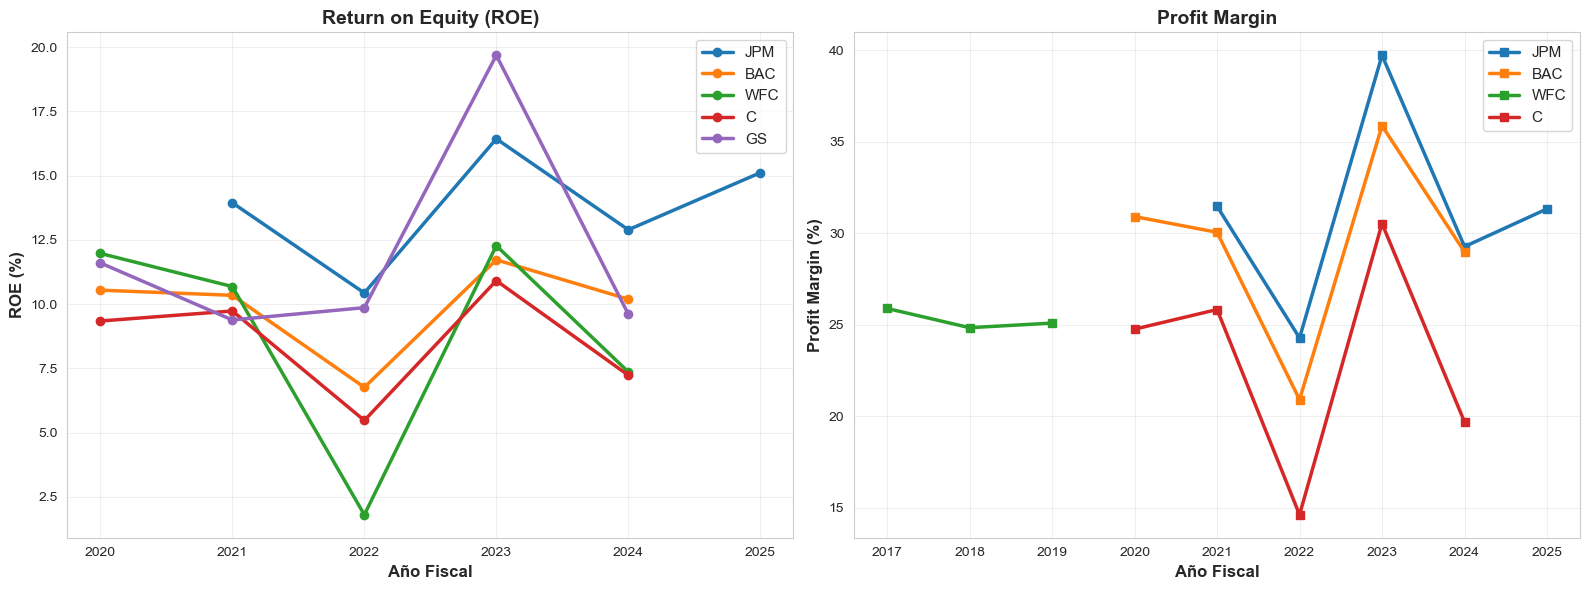

In [17]:
# Gráfico de ROE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROE
for ticker in EMPRESAS_EJEMPLO:
    df = calcular_roe(ticker, years=5)
    if not df.empty:
        ax1.plot(df['fiscal_year'], df['ROE'], marker='o', linewidth=2.5, label=ticker)

ax1.set_xlabel('Año Fiscal', fontsize=12, fontweight='bold')
ax1.set_ylabel('ROE (%)', fontsize=12, fontweight='bold')
ax1.set_title('Return on Equity (ROE)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Profit Margin
for ticker in EMPRESAS_EJEMPLO:
    df = calcular_profit_margin(ticker, years=5)
    if not df.empty:
        ax2.plot(df['fiscal_year'], df['profit_margin'], marker='s', linewidth=2.5, label=ticker)

ax2.set_xlabel('Año Fiscal', fontsize=12, fontweight='bold')
ax2.set_ylabel('Profit Margin (%)', fontsize=12, fontweight='bold')
ax2.set_title('Profit Margin', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ratios_comparison.png', dpi=300, bbox_inches='tight')
print("📊 Gráfico guardado: ratios_comparison.png")
plt.show()

## 📈 Celda 17: Análisis de Crecimiento (CAGR)

In [18]:
print("📈 Compound Annual Growth Rate (CAGR) - Últimos 5 años\n")
print("="*80)

print("\n💰 Revenues CAGR:\n")
for ticker in EMPRESAS_EJEMPLO:
    resultado = calcular_cagr(ticker, 'Revenues', years=5)
    if resultado:
        print(f"{ticker}: {resultado['cagr']}% anual")
        print(f"  ${resultado['valor_inicial']/1e9:.2f}B → ${resultado['valor_final']/1e9:.2f}B\n")

print("\n💵 Net Income CAGR:\n")
for ticker in EMPRESAS_EJEMPLO:
    resultado = calcular_cagr(ticker, 'NetIncomeLoss', years=5)
    if resultado:
        print(f"{ticker}: {resultado['cagr']}% anual")
        print(f"  ${resultado['valor_inicial']/1e9:.2f}B → ${resultado['valor_final']/1e9:.2f}B\n")

📈 Compound Annual Growth Rate (CAGR) - Últimos 5 años


💰 Revenues CAGR:

JPM: 8.04% anual
  $71.37B → $97.23B

BAC: 8.74% anual
  $66.83B → $93.45B

WFC: 0.0% anual
  $88.39B → $88.39B

C: 0.01% anual
  $77.30B → $77.33B


💵 Net Income CAGR:

JPM: 5.42% anual
  $15.37B → $18.98B

BAC: -44.26% anual
  $14.98B → $1.45B

WFC: 18.47% anual
  $8.06B → $15.87B

C: 32.26% anual
  $3.62B → $11.07B

GS: -21.33% anual
  $11.60B → $4.44B

